<a href="https://colab.research.google.com/github/escapingLife/mashinePrograming/blob/master/11%EC%A3%BC%EC%B0%A8/WISDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# -----------------------------------------------------------
# 데이터 로드 및 전처리.
# -----------------------------------------------------------

df = pd.read_csv('/content/drive/MyDrive/WISDM.csv')

df = df.drop(columns=['0', '33'], errors='ignore')

df

,Jogging,4.9106E+13,-0.6946377,12.680544,0.50395286
0,Jogging,4.910610e+13,5.012288,11.264028,0.953424
1,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
2,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
3,Jogging,4.910630e+13,-1.184970,12.108489,7.205164
4,Jogging,4.910640e+13,1.375655,-2.492524,-6.510526
...,...,...,...,...,...
1048569,Standing,2.091650e+14,-7.930000,5.430000,-0.990000
1048570,Standing,2.091660e+14,-7.970000,5.130000,-1.140000
1048571,Standing,2.091660e+14,-7.970000,5.220000,-1.380000
1048572,Standing,2.091660e+14,-7.930000,5.600000,-1.180000


In [2]:
# -----------------------------------------------------------
# 컬럼 이름 지정
# -----------------------------------------------------------
df.columns = ['activity', 'timestamp', 'x', 'y', 'z']

In [3]:
# -----------------------------------------------------------
# 결측치 제거
# -----------------------------------------------------------
df = df.dropna()

In [4]:
# -----------------------------------------------------------
# Jogging, Sitting만 선택
# -----------------------------------------------------------
df = df[df['activity'].isin(['Jogging', 'Sitting'])]

In [5]:
# -----------------------------------------------------------
# 라벨링: Jogging → 0 (Normal), Sitting → 1 (Abnormal)
# -----------------------------------------------------------
df['Class'] = df['activity'].apply(lambda x: 0 if x == 'Jogging' else 1)
LABELS = ['Normal (Jogging)', 'Abnormal (Sitting)']

print(df['Class'].value_counts())

Class
0    325974
1     54876
Name: count, dtype: int64


/tmp/ipython-input-2743670465.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort=True)


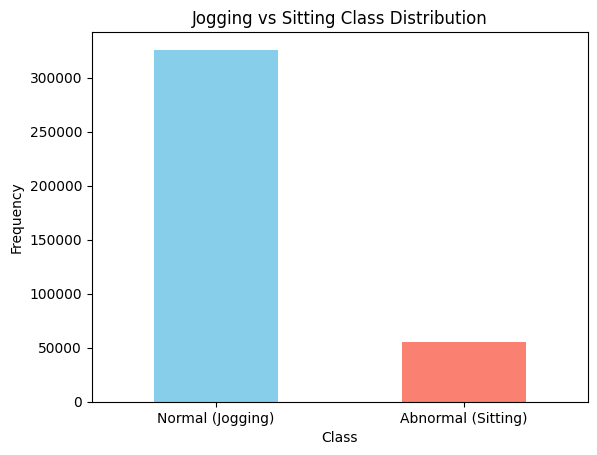

In [15]:
# -----------------------------------------------------------
# 데이터 분포 시각화
# -----------------------------------------------------------
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0, color=['skyblue', 'salmon'])
plt.title("Jogging vs Sitting Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


In [16]:
# -----------------------------------------------------------
# timestamp 제거 및 특징 스케일링
# -----------------------------------------------------------
data = df.drop(['activity', 'timestamp'], axis=1)
scaler = StandardScaler()
data[['x', 'y', 'z']] = scaler.fit_transform(data[['x', 'y', 'z']])

In [18]:
# -----------------------------------------------------------
# 학습/테스트 데이터 분리
# -----------------------------------------------------------
RANDOM_SEED = 42
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

# Normal (Jogging)만 학습
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (260819, 3)
Test shape: (76170, 3)


In [19]:
# -----------------------------------------------------------
# 오토인코더 모델 정의
# -----------------------------------------------------------
input_dim = X_train.shape[1]
encoding_dim = 8

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [20]:
# -----------------------------------------------------------
# 모델 학습
# -----------------------------------------------------------
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.1)

Epoch 1/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.1641 - val_loss: 0.7458
Epoch 2/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7133 - val_loss: 0.6679
Epoch 3/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6729 - val_loss: 0.6554
Epoch 4/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6599 - val_loss: 0.6484
Epoch 5/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6544 - val_loss: 0.6420
Epoch 6/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6490 - val_loss: 0.6375
Epoch 7/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6426 - val_loss: 0.6346
Epoch 8/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6411 - val_loss: 0.6328
Epoch 9/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6395 - val_loss: 0.6317
Epoch 10/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6361 - val_loss: 0.6310
Epoch 11/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6396 - val_loss: 0.6306
Epoch 12/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

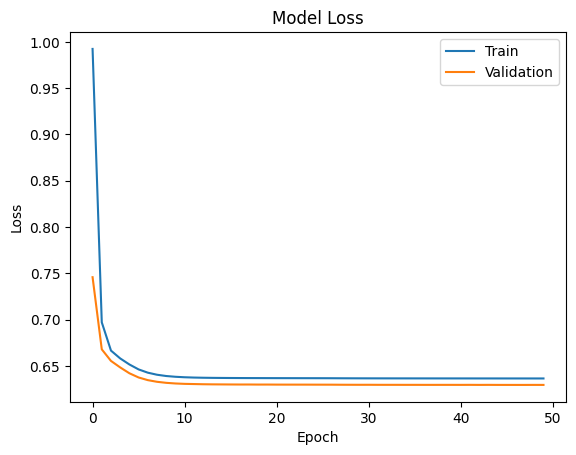

In [21]:
# -----------------------------------------------------------
# 학습 곡선 시각화
# -----------------------------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [22]:
# -----------------------------------------------------------
# Reconstruction Error 계산
# -----------------------------------------------------------
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.head()

2381/2381 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


,reconstruction_error,true_class
469045,0.046291,1
169577,0.062997,0
639903,0.238909,1
962556,2.281268,0
546410,0.065951,0


In [23]:
# -----------------------------------------------------------
# Threshold 설정 (상위 85%를 이상치로)
# -----------------------------------------------------------
threshold = np.percentile(error_df.reconstruction_error, 95)

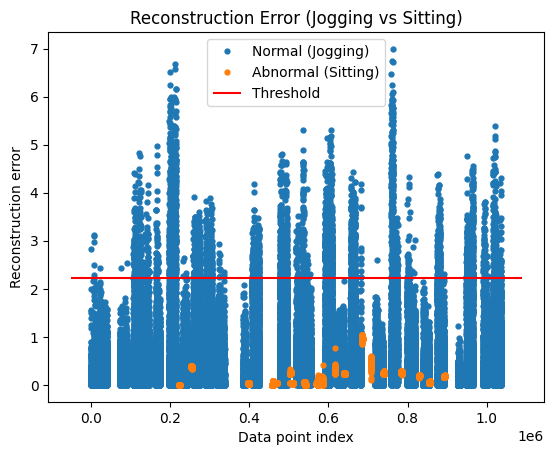

In [24]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label='Abnormal (Sitting)' if name == 1 else 'Normal (Jogging)')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", label='Threshold')
ax.legend()
plt.title("Reconstruction Error (Jogging vs Sitting)")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

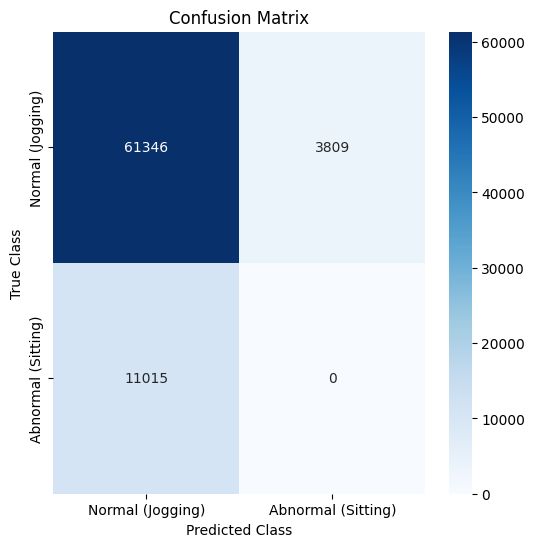

                    precision    recall  f1-score   support

  Normal (Jogging)       0.85      0.94      0.89     65155
Abnormal (Sitting)       0.00      0.00      0.00     11015

          accuracy                           0.81     76170
         macro avg       0.42      0.47      0.45     76170
      weighted avg       0.73      0.81      0.76     76170



In [25]:
# -----------------------------------------------------------
# 평가
# -----------------------------------------------------------
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

print(classification_report(error_df.true_class, y_pred, target_names=LABELS))